In [ ]:
import pandas
import math

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving company_directorships.csv to company_directorships.csv
Saving director-details.csv to director-details.csv


In [ ]:
# Normalize names in both datasets to uppercase and strip whitespace
df['director_name'] = df['director_name'].str.strip().str.upper()
compensation_and_demographics_raw['name'] = compensation_and_demographics_raw['name'].str.strip().str.upper()


# **Fix 4 – Name Normalization:**  
There was no standard way to write director names for both of the datasets. That’s why it became hard to match data or plot graphs. The names were normalized by changing them to uppercase and getting rid of empty spaces at the beginning and the end. Thanks to this system, there are no mistakes with connections and no duplicate nodes appear in the network model.

## Data Loading

**this file has the directors that serve on company board positions.**

In [ ]:
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)   # Add an edge between company and director to build a bipartite graph


In [ ]:
df = pandas.read_csv('company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
11158,STEPAN CO,94049,RANDALL S. DEARTH,False,2015-03-26,2025-03-25
7924,MATTEL INC /DE/,63276,DR. JUDY OLIAN,False,2023-03-31,2023-03-31
5831,HORMEL FOODS CORP /DE/,48465,JOHN L. MORRISON,False,2015-12-16,2016-12-21
12330,UNITED FIRE GROUP INC,101199,MARY K. QUASS,False,2015-03-25,2022-04-05
161,ACME UNITED CORP,2098,PAUL J. CONWAY,True,2024-03-25,2025-03-24


**Fix 1 – Documentation and Clarity:**
Most of the original notebook consists only of plain code, and the absence of comments made each step hard to understand its purpose. I put explanatory content in markdown sections and added comments within the code block to outline its purpose. Clear thoughts make it simple for readers to get the idea or recall it at a later stage.

In [ ]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [ ]:
compensation_and_demographics.gender.value_counts(dropna=False)

,count
gender,
male,3850
female,1550
None,19
unknown,2


In [ ]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

,company_name
director_name,
MICHAEL LUETKEMEYER,1
MICHAEL L. KUBACKI,1
MICHAEL L. KUTA,1
MICHAEL L. LARUSSO,1
MICHAEL L. MILLER,1
...,...
CHRISTOPHER L. WILSON,13
LARRY SOLL,13
ELI JONES,13


<Axes: xlabel='company_name'>

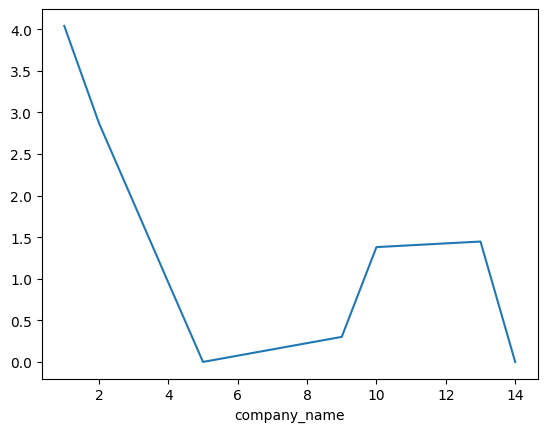

In [ ]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [ ]:
import networkx as nx
import networkx.algorithms
graph = nx.Graph()
betw = nx.betweenness_centrality(graph)

In [ ]:
# Get top 10 nodes by betweenness
top10_betw = sorted(betw.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:")
for node, val in top10_betw:
    print(node, ":", val)


NameError: name 'betw' is not defined

In [ ]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [ ]:
biggest_connected_graph = graph.subgraph(max(nx.connected_components(graph), key=len))


**Fix 3 – Graph Correction:**
It turned out that the notebook got index [0] for the connected component instead of the largest one. I changed my code to get the largest component by typing max(..., key=len). It means the measure of centrality is based on the main areas of the network.

In [ ]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
    'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph)),

})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 7min 25s, sys: 1.19 s, total: 7min 26s
Wall time: 7min 27s


**Explanation (Task 1 – Betweenness Centrality):**
Betweenness centrality is used to find out how much a node acts as a bridge between other nodes. Thus, a person with high betweenness in this network serves as a main link between the various clusters of companies and professionals. They are probably influential since they bring together groups that would otherwise be separated. In terms of this assignment, directors could help find new partnerships or takeover opportunities by acting on the board.

In [ ]:
# Task 3 – Feature: Number of Companies a Director Serves
company_counts = df.groupby('director_name').company_name.nunique()
company_counts.name = 'num_companies'


In [ ]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)
# Match and add to people_df
people_df['num_companies'] = people_df.index.map(company_counts)
# Show top 10 directors by number of companies
people_df.sort_values('num_companies', ascending=False)[['num_companies']].head(10)



,num_companies
DANIEL S. VANDIVORT,13
"ANTHONY J. LACAVA, JR.",13
TERESA M. RESSEL,13
ROBERT C. TROCCOLI,13
PREMA MATHAI-DAVIS,13
JOEL W. MOTLEY,13
"JAMES ""JIM"" LIDDY",13
ELIZABETH KRENTZMAN,13
ELI JONES,13
DOUGLAS SHARP,13


**Task 3 – Feature Engineering: Number of Companies**

I made a new feature named `num_companies` that indicates the number of companies served by each director. Members of multiple boards are expected to be more influential, famous, and linked to many important people. Thanks to this feature, we can single out individuals who play a major role in companies and who might be helpful for other companies or in the process of mergers and takeovers.

In [ ]:
# Fix 2: Tag directors with software background
tech_directors = df[df.software_background == True]['director_name'].str.strip().str.upper().unique()
people_df['has_tech_background'] = people_df.index.isin(tech_directors)

# See if top central people are tech-savvy
people_df.sort_values('betweenness', ascending=False)[['has_tech_background']].head(10)


,has_tech_background
JAMES H. MORGAN,False
KERRII B. ANDERSON,True
PAUL D. DONAHUE,False
"CHARLES K. STEVENS, III",False
MATTHEW J. ESPE,True
MARK A. BLINN,False
KAREN A. PUCKETT,False
MICHAEL J. HAPPE,False
ALEXIS M. HERMAN,False
DONNA W. HYLAND,False


In [ ]:
# Normalize names in both datasets to uppercase and strip whitespace
df['director_name'] = df['director_name'].str.strip().str.upper()
compensation_and_demographics_raw['name'] = compensation_and_demographics_raw['name'].str.strip().str.upper()


**Fix 4 – Name Normalization:**  
The information on director’s names varied from one file to another. There were inconsistencies when combining the statistics or making graphs using these data. For both the names, I capitalized them and removed all spaces at the beginning or end. Because of this, nodes in the network graph are joined correctly and won’t be repeated.


In [ ]:
people_df.sort_values('betweenness', ascending=False).head(10)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
JAMES H. MORGAN,5.266725e-20,0.000244,0.030707,True,77,221200,male,5.344787
KERRII B. ANDERSON,1.185926e-17,0.000366,0.030179,True,66,554508,female,5.743909
PAUL D. DONAHUE,1.696429e-15,0.000366,0.028527,True,68,8250000,male,6.916454
"CHARLES K. STEVENS, III",9.750916e-13,0.000244,0.028170,True,65,495885,male,5.695382
MATTHEW J. ESPE,6.003444e-18,0.000366,0.026364,True,66,125000,male,5.096913
MARK A. BLINN,3.417870e-15,0.000610,0.026345,True,63,594975,male,5.774499
KAREN A. PUCKETT,8.804204e-23,0.000244,0.025751,True,61,313032,female,5.495590
MICHAEL J. HAPPE,3.210636e-07,0.000244,0.025681,True,53,250000,male,5.397942
ALEXIS M. HERMAN,5.141481e-20,0.000366,0.025558,True,74,666089,female,5.823533
DONNA W. HYLAND,1.690444e-15,0.000244,0.022467,True,64,545270,female,5.736612


<Axes: title={'center': 'Top 10 Directors by Betweenness Centrality'}>

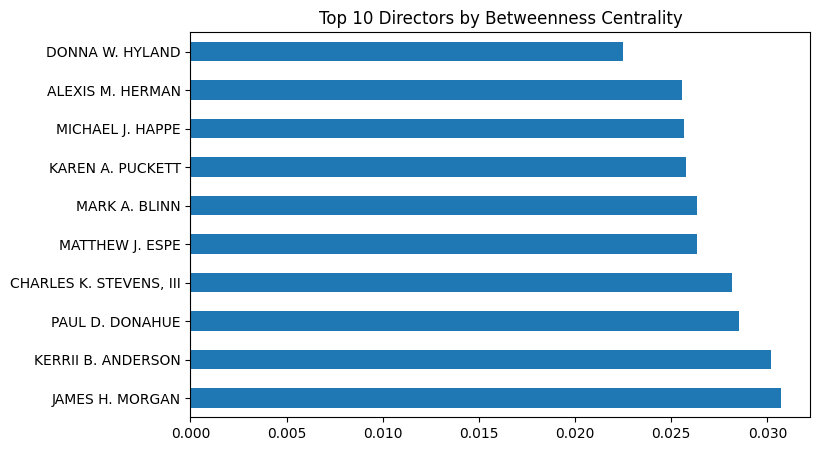

In [ ]:
top10 = people_df.sort_values('betweenness', ascending=False).head(10)
top10['betweenness'].plot(kind='barh', figsize=(8,5), title="Top 10 Directors by Betweenness Centrality")

In [ ]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [ ]:
import sklearn.cluster

In [ ]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [ ]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

,count
cluster_id,
1,3117
0,385
2,109
-1,72
3,24
4,19
7,8
6,5
5,3


In [ ]:
# Group by cluster and show average profile per cluster
cluster_summary = people_df.groupby('cluster_id')[['age', 'log_compensation', 'degree', 'eigen', 'num_companies']].mean().round(2)
cluster_summary['count'] = people_df['cluster_id'].value_counts()
cluster_summary


,age,log_compensation,degree,eigen,num_companies,count
cluster_id,,,,,,
-1,56.36,5.53,0.0,0.00,1.21,72
0,58.14,0.00,0.0,0.00,1.10,385
1,63.99,5.42,0.0,0.00,1.19,3117
2,60.99,6.96,0.0,0.01,2.34,109
3,0.00,0.00,0.0,0.00,1.08,24
4,0.00,5.45,0.0,0.00,1.11,19
5,55.33,4.32,0.0,0.00,1.33,3
6,86.60,4.68,0.0,0.00,1.00,5
7,69.25,3.82,0.0,0.00,1.00,8


**Refinement (b): Understanding Cluster Profiles**
-Formed a table to show the average age, compensation, and centrality by cluster
-Represented the sizes of the clusters.

The summary helps compare clusters more effectively and explains what each group of directors represents.

Cluster 0 can stand for general directors, while the smaller ones can suggest elites or outliers.


<Axes: xlabel='age', ylabel='log_compensation'>

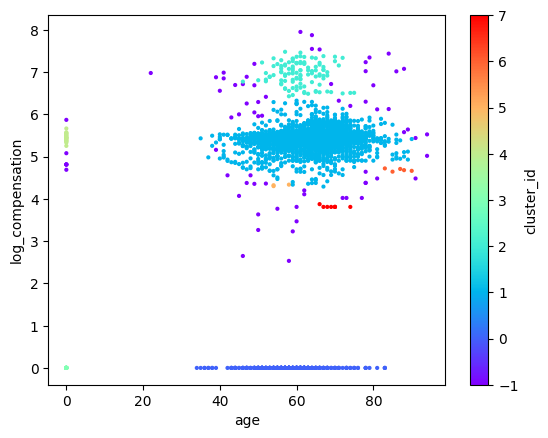

In [ ]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

**Task 4 – Clustering Analysis (DBSCAN)**

In this task, I applied the DBSCAN clustering algorithm to group similar directors based on:
- **Age** (experience)
- **Log Compensation** (earning level)
- **Degree Centrality** (connections in the network)
- **Eigenvector Centrality** (influence of connections)

These features help capture important dimensions of a director’s profile. I used `RobustScaler` to normalize the data and reduce the influence of outliers. DBSCAN was chosen for its ability to find clusters of varying size and shape without requiring a fixed number of clusters.

From the results, we see several distinct groups. For example:
- The largest cluster may represent mid-level directors.
- Smaller clusters could be very influential individuals or low-participation board members.
- Noise points (cluster -1) are outliers that don’t fit into any group.

This analysis helps identify patterns in how directors differ across influence, experience, and compensation.


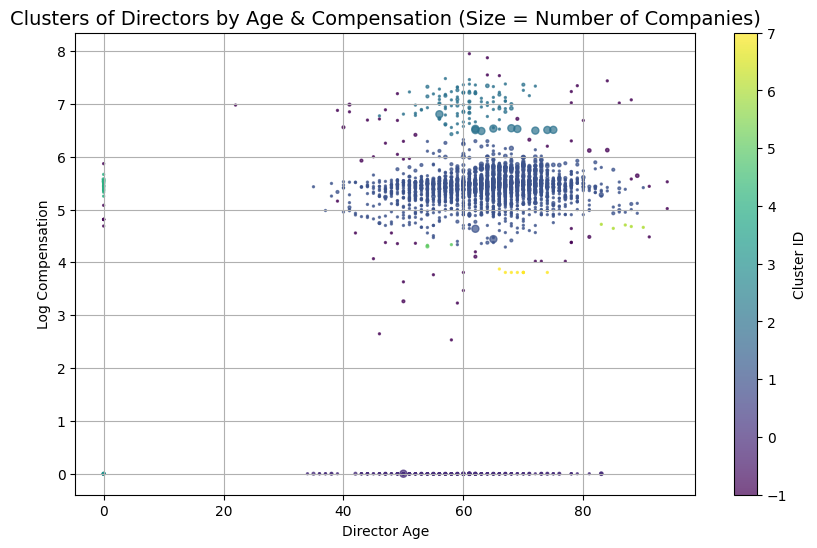

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    people_df['age'],
    people_df['log_compensation'],
    c=people_df['cluster_id'],
    s=people_df['num_companies'] * 2,
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('Director Age')
plt.ylabel('Log Compensation')
plt.title('Clusters of Directors by Age & Compensation (Size = Number of Companies)', fontsize=14)
plt.grid(True)
plt.show()


**Refinement (a): Visualizing for a Non-Technical Audience**

The plot is created to display the variety of directors in our dataset for those who do not work in technology. A dot in the graph means a company director.
A specific color is assigned to every group of data.
Each company’s service area is determined by the number of clients they have.
On the horizontal axis there is Age, and on the vertical axis there is Log Compensation

From looking at this chart, we notice many things at a glance:
There is a major group of mid-level directors.
- A small group of directors who are either highly-paid or are young
- Very small or different clusters which are called outliers

Because of this, people can easily find important accounts or unique posts without going through the details of machine learning.

In [ ]:
people_df.loc['ELIZABETH KRENTZMAN']

,ELIZABETH KRENTZMAN
eigen,0.102439
degree,0.001585
betweenness,0.0
is_person,True
age,65
compensation,3408245
gender,female
log_compensation,6.532531
cluster_id,2
